# Air Passengers Forcasting with ARIMA, SARIMA, and SARIMAX

## Enviroment and Dataset Preparation

### Importing Libraries

In [1]:
!pip install pipreqs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-v0_8-whitegrid')

### Loading Dataset

In [14]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
passengers_df = pd.read_csv(url)

passengers_df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Exploratory Data Analysis

### Dataset Shape

In [15]:
passengers_df.shape

(144, 2)

### Dataset Summary

In [16]:
passengers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### Handling Missing Values

In [17]:
print(f'Jumlah missing values: \n{(passengers_df.isna() | passengers_df.isnull() | passengers_df.empty).sum()}')

Jumlah missing values: 
Month         0
Passengers    0
dtype: int64


### Handling Duplicated Values

In [18]:
passengers_df.drop_duplicates(inplace=True)
if passengers_df.duplicated().sum() == 0:
  print('Sudah tidak ada duplikat')
else:
  print('Terdapat duplikat data')

Sudah tidak ada duplikat


### Data Pre-processing

In [19]:
passengers_df.rename(columns={'Month': 'Date', 'Passengers': 'Passengers'}, inplace=True)
passengers_df['Date'] = pd.to_datetime(passengers_df['Date'], format='%Y-%m')
passengers_df.set_index('Date', inplace=True)

In [20]:
passengers_df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Visualization

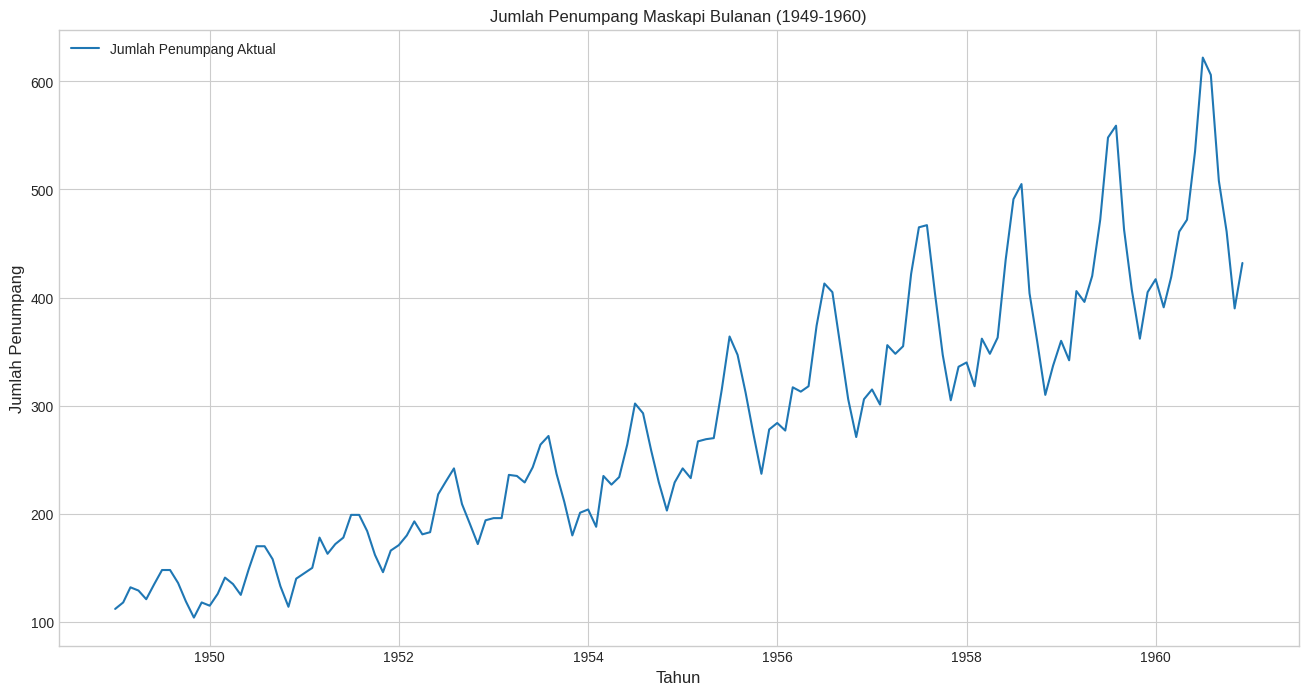

In [21]:
plt.figure(figsize=(16, 8))
plt.plot(passengers_df.index, passengers_df['Passengers'], label='Jumlah Penumpang Aktual')
plt.title('Jumlah Penumpang Maskapi Bulanan (1949-1960)')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Penumpang', fontsize=12)
plt.legend()

plt.show()

## Stationarity and Differentiation Test

Model ARIMA mengharuskan data bersifat stasioner. Artinya, rata-rata, varians, dan autokorelasi data tidak berubah seiring waktu. Data saat ini jelas tidak stasioner karena adanya tren dan musiman. Maka dari itu akan menggunakan Uji Augmented Dickey-Fuller (ADF) untuk menguji stasioneritas secara statistik.

- Hipotesis Nol (H0): Data tidak stasioner.

- Hipotesis Alternatif (H1): Data stasioner.

Jika **p-value > 0.05**, kita gagal menolak H0, yang berarti data tidak stasioner.

### Augmented Dickey-Fuller (ADF)

In [22]:
def adf_test(series, title=''):
    print(f'Uji Augmented Dickey-Fuller: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print("-> Data stasioner (p-value <= 0.05)")
    else:
        print("-> Data tidak stasioner (p-value > 0.05)")

adf_test(passengers_df['Passengers'], 'Data Asli')

Uji Augmented Dickey-Fuller: Data Asli
ADF Test Statistic : 0.8153688792060498
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
-> Data tidak stasioner (p-value > 0.05)


Hasil p-value yang sangat tinggi mengkonfirmasi bahwa data tidak stasioner. Untuk membuatnya stasioner, perlu dilakukan diferensiasi (differencing). Mengambil selisih antara satu titik data dengan titik data sebelumnya. Karena ada musiman tahunan (12 bulan), maka perlu juga dilakukan diferensiasi musiman.

In [23]:
passengers_df['diff_1'] = passengers_df['Passengers'].diff()

passengers_df['diff_seasonal_12'] = passengers_df['Passengers'].diff(periods=12)

passengers_df['diff_1_seasonal_12'] = passengers_df['diff_1'].diff(12)

adf_test(passengers_df['diff_1_seasonal_12'], 'Data Setelah Differencing Pertama dan Musiman')

Uji Augmented Dickey-Fuller: Data Setelah Differencing Pertama dan Musiman
ADF Test Statistic : -15.595618083746338
p-value : 1.856511600123444e-28
#Lags Used : 0
Number of Observations Used : 130
-> Data stasioner (p-value <= 0.05)


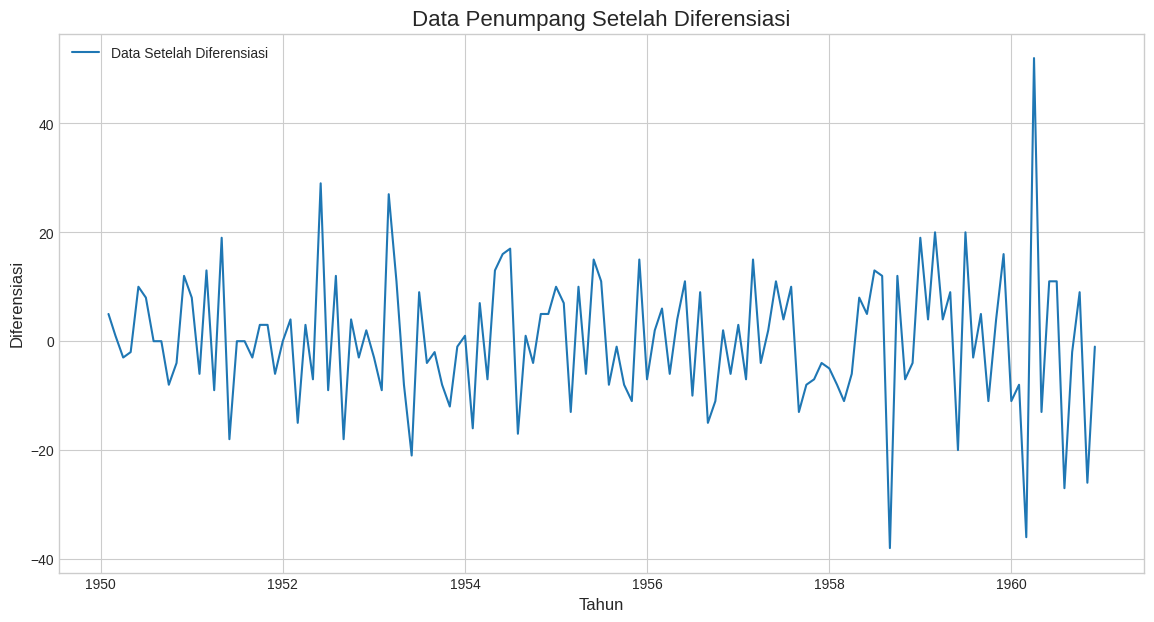

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(passengers_df.index, passengers_df['diff_1_seasonal_12'], label='Data Setelah Diferensiasi')
plt.title('Data Penumpang Setelah Diferensiasi', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Diferensiasi', fontsize=12)
plt.legend()
plt.show()

## Order Model Indetification (ACF  & PACF)

Menentukan orde untuk model ARIMA(p, d, q).

- **p (AutoRegressive/AR)**: Jumlah observasi lampau yang dimasukkan ke dalam model. Ditentukan dari plot PACF (Partial Autocorrelation Function).

- **d (Integrated/I)**: Berapa kali data didiferensiasi. Kita melakukan 1 kali diferensiasi non-musiman dan 1 kali musiman. Jadi `d=1`.

- **q (Moving Average/MA)**: Jumlah error prediksi lampau yang dimasukkan ke dalam model. Ditentukan dari plot ACF (Autocorrelation Function).

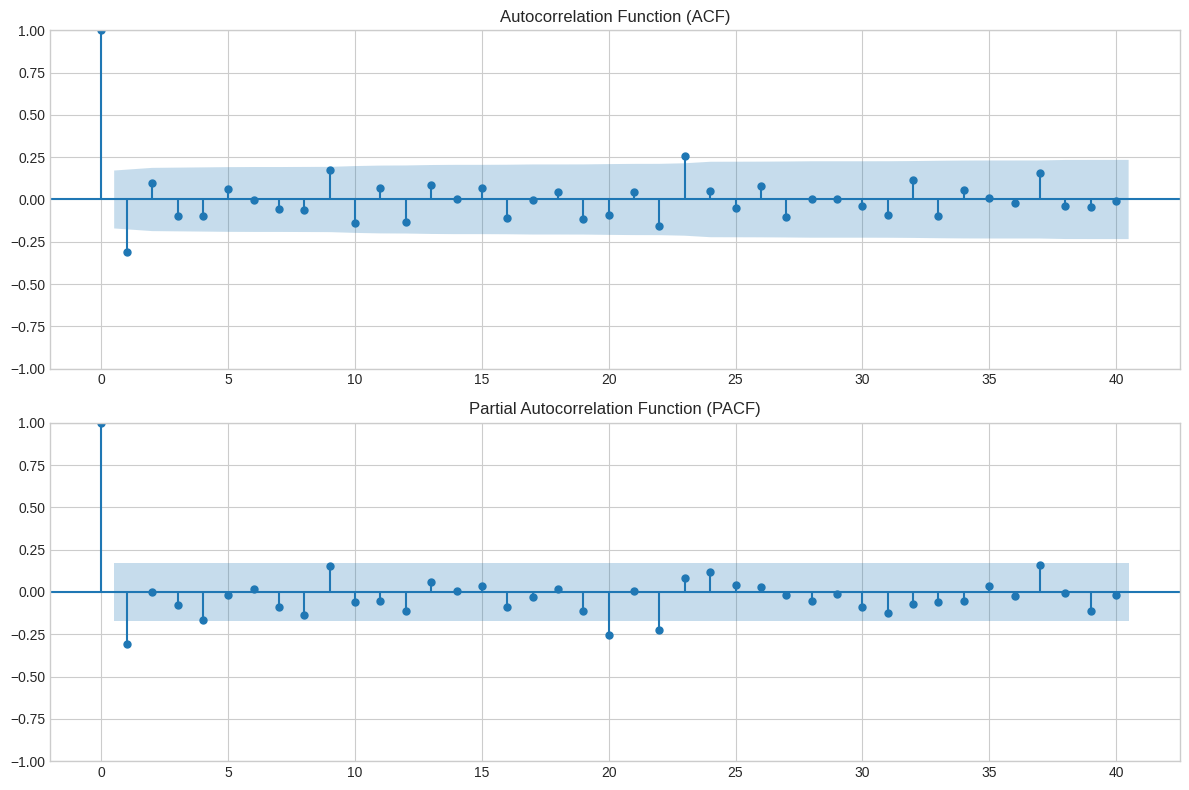

In [26]:
# Plot ACF dan PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(passengers_df['diff_1_seasonal_12'].dropna(), ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(passengers_df['diff_1_seasonal_12'].dropna(), ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

1. ACF (Autocorrelation Function)
    - Grafik ini menunjukkan hubungan antara data sekarang dengan data masa lalu (lag).

    - Titik pada sumbu-x menunjukkan jarak waktu (lag), sedangkan tinggi garis pada sumbu-y menunjukkan seberapa kuat hubungan (korelasi).

    - Garis biru horizontal adalah batas kepercayaan. Jika batang melewati batas ini, artinya hubungan pada lag tersebut signifikan secara statistik.

    - Pada grafik ini:

        - Lag-0 pasti selalu 1 karena itu data dengan dirinya sendiri.

        - Sisanya (lag 1 hingga 40), sebagian besar batang berada di dalam batas kepercayaan, yang menunjukkan bahwa tidak banyak autocorrelation signifikan.
        
        - Artinya, data mungkin cukup acak atau sudah stasioner, cocok untuk modelling.

2. PACF (Partial Autocorrelation Function)
    - Menunjukkan hubungan langsung antara data sekarang dengan data masa lalu, setelah menghilangkan pengaruh lag lainnya.

    - Misalnya, PACF pada lag-2 menunjukkan hubungan data sekarang dengan data 2 langkah sebelumnya, setelah menghapus efek dari lag-1.

    - Tujuan PACF adalah membantu menentukan berapa banyak lag AR (Autoregressive) yang dibutuhkan.

    - Pada grafik ini:

      - Hanya lag-0 yang sangat signifikan, dan mungkin satu-dua lag berikutnya sedikit menonjol.

      - Artinya, komponen AR yang diperlukan tidak terlalu banyak, misalnya AR(1) atau AR(2) saja cukup.

## Modelling

In [28]:
# Bagi data menjadi train dan test
train_size = int(len(passengers_df) * 0.8)
train_data, test_data = passengers_df['Passengers'][0:train_size], passengers_df['Passengers'][train_size:]

### ARIMA

Membangun model ARIMA yang sederhana karena model ini tidak memperhitungkan musiman, jadi harapannya performanya tidak akan optimal, tetapi ini akan menjadi baseline yang baik.

In [29]:
# Berdasarkan analisis sebelumnya, dilakukan pengujia ndengan p=1, d=1, q=1
p, d, q = 1, 1, 1

In [30]:
# Bangun model
model_arima = ARIMA(train_data, order=(p,d,q))
fit_arima = model_arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
# Buat prediksi
start_index = len(train_data)
end_index = len(passengers_df) - 1
predictions_arima = fit_arima.predict(start=start_index, end=end_index, typ='levels')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [33]:
# Hitung evaluasi
rmse_arima = np.sqrt(mean_squared_error(test_data, predictions_arima))
print(f"RMSE Model ARIMA: {rmse_arima:.2f}")

RMSE Model ARIMA: 97.50


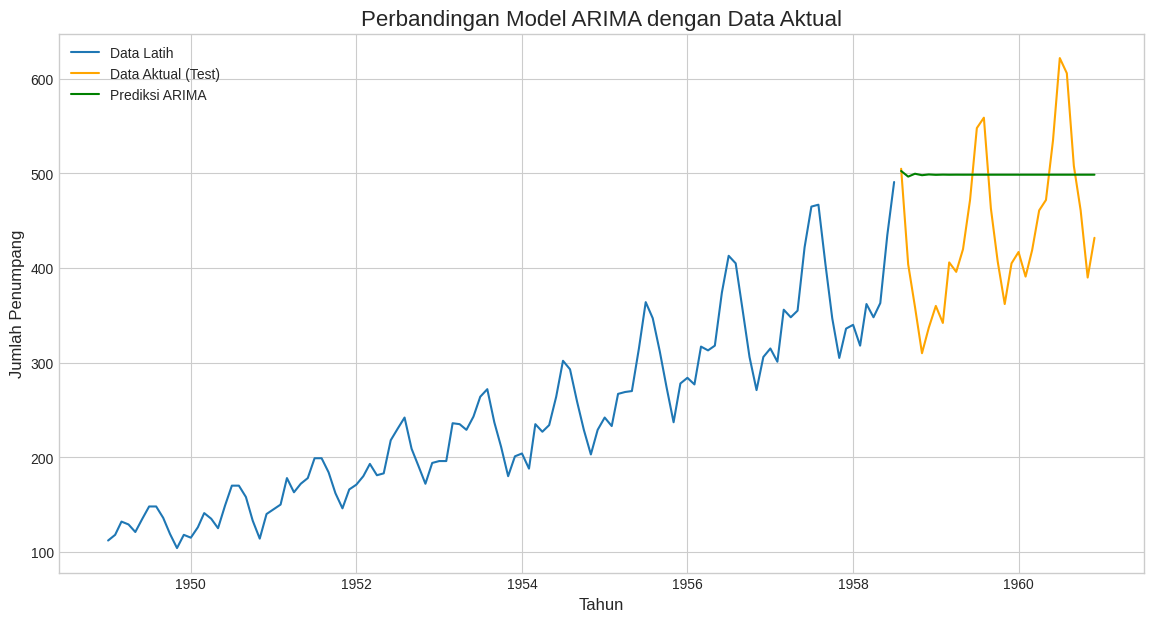

In [34]:
# Visualisasi hasil
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Data Latih')
plt.plot(test_data.index, test_data, label='Data Aktual (Test)', color='orange')
plt.plot(predictions_arima.index, predictions_arima, label='Prediksi ARIMA', color='green')
plt.title('Perbandingan Model ARIMA dengan Data Aktual', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Penumpang', fontsize=12)
plt.legend()
plt.show()


### SARIMA

Seasonal ARIMA Model (SARIMA) adalah perpanjangan dari ARIMA yang secara eksplisit memperhitungkan musiman. Orde modelnya adalah SARIMA(p,d,q)(P,D,Q,m).

- `(p,d,q)`: Orde non-musiman (sama seperti ARIMA).

- `(P,D,Q,m)`: Orde musiman.

    - `P`: Orde AR musiman.

    - `D`: Orde diferensiasi musiman.

    - `Q`: Orde MA musiman.

    - `m`: Periode musiman (12 untuk data bulanan).

In [35]:
# SARIMA parameter
# (p,d,q) = (1,1,1)
# (P,D,Q,m) = (1,1,1,12)
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 12

In [36]:
# Bangun model
model_sarima = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
fit_sarima = model_sarima.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [37]:
# Buat prediksi
predictions_sarima = fit_sarima.predict(start=start_index, end=end_index, typ='levels')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [38]:
# Hitung evluasi
rmse_sarima = np.sqrt(mean_squared_error(test_data, predictions_sarima))
print(f"RMSE Model SARIMA: {rmse_sarima:.2f}")

RMSE Model SARIMA: 30.14


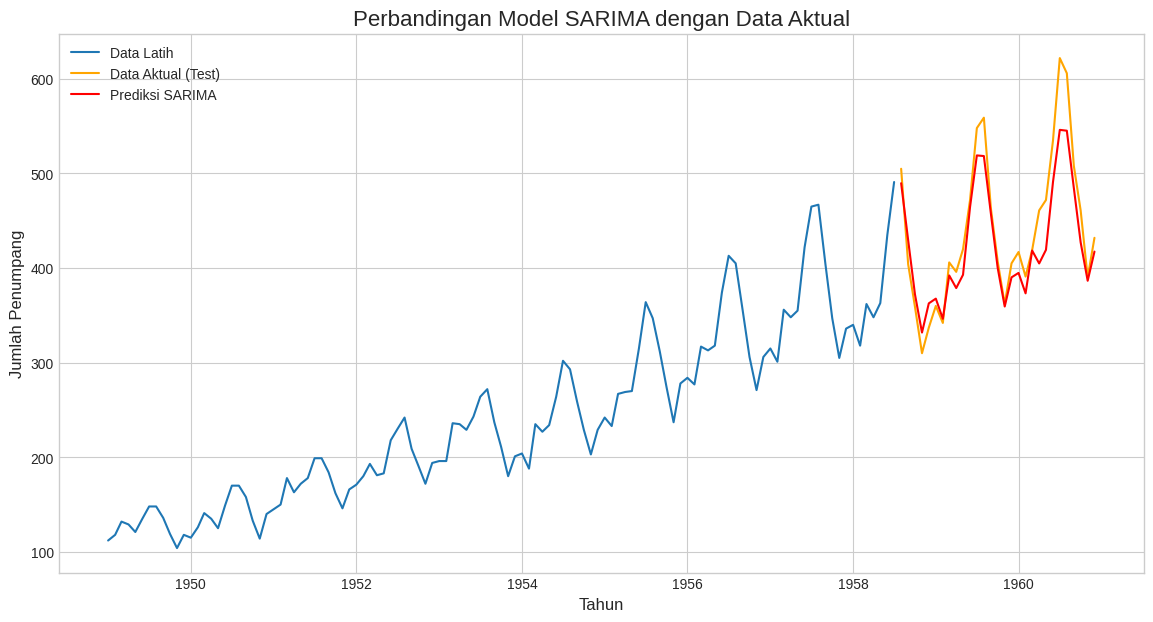

In [39]:
# Visualisasi hasil
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Data Latih')
plt.plot(test_data.index, test_data, label='Data Aktual (Test)', color='orange')
plt.plot(predictions_sarima.index, predictions_sarima, label='Prediksi SARIMA', color='red')
plt.title('Perbandingan Model SARIMA dengan Data Aktual', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Penumpang', fontsize=12)
plt.legend()
plt.show()


### SARIMAX

Model SARIMAX adalah langkah selanjutnya, di mana 'X' berarti eksogen (exogenous). Model ini memungkinkan untuk menambahkan variabel eksternal yang diyakini dapat memengaruhi variabel target.

Untuk tujuan demonstrasi, akan dibuatkan variabel eksogen sederhana: sebuah variabel tren yang hanya berupa angka yang terus meningkat. Dalam kasus nyata, ini bisa berupa data PDB, hari libur, harga bahan bakar, dll.

In [40]:
# Buat variabel eksogen (tren waktu)
train_exog = pd.DataFrame({'tren': np.arange(1, len(train_data) + 1)}, index=train_data.index)
test_exog = pd.DataFrame({'tren': np.arange(len(train_data) + 1, len(passengers_df) + 1)}, index=test_data.index)

In [41]:
# Bangun model
model_sarimax = SARIMAX(train_data, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, m))
fit_sarimax = model_sarimax.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
# Buat prediksi, pastikan untuk menyertakan variabel eksogen untuk periode prediksi
predictions_sarimax = fit_sarimax.predict(start=start_index, end=end_index, exog=test_exog, typ='levels')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [43]:
# Hitung evaluasi
rmse_sarimax = np.sqrt(mean_squared_error(test_data, predictions_sarimax))
print(f"RMSE Model SARIMAX: {rmse_sarimax:.2f}")

RMSE Model SARIMAX: 30.14


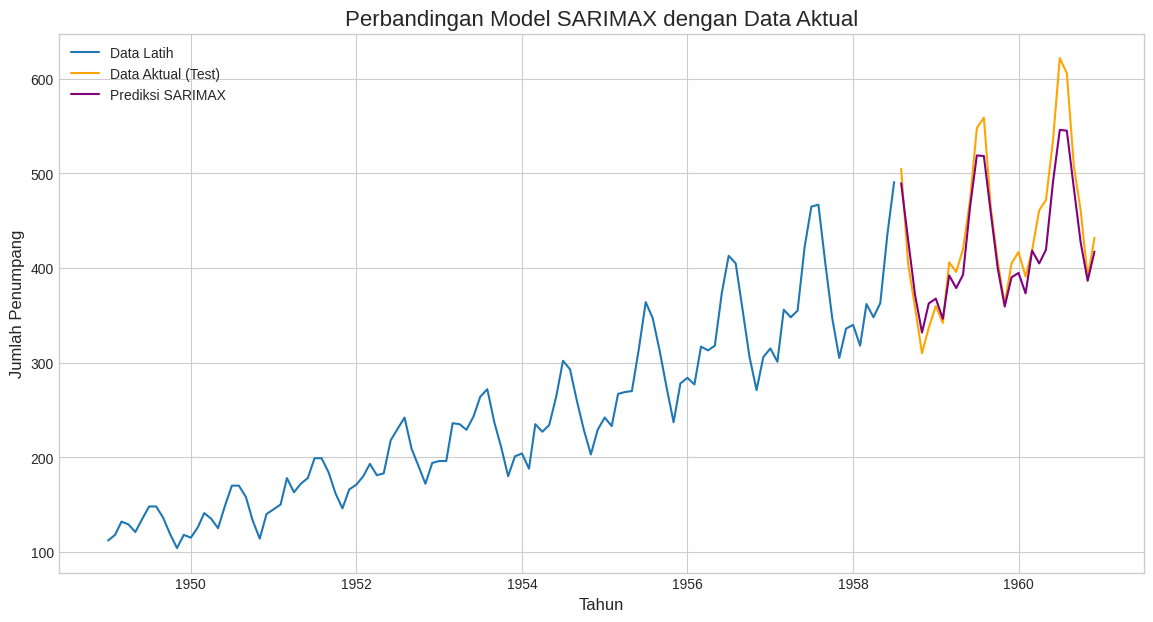

In [44]:
# Visualisasi hasil
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Data Latih')
plt.plot(test_data.index, test_data, label='Data Aktual (Test)', color='orange')
plt.plot(predictions_sarimax.index, predictions_sarimax, label='Prediksi SARIMAX', color='purple')
plt.title('Perbandingan Model SARIMAX dengan Data Aktual', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Penumpang', fontsize=12)
plt.legend()
plt.show()

## Summary


--- Ringkasan Hasil Pengujian Model ---
RMSE Model ARIMA: 97.50
RMSE Model SARIMA: 30.14
RMSE Model SARIMAX: 30.14

Model terbaik adalah SARIMAX berdasarkan RMSE.


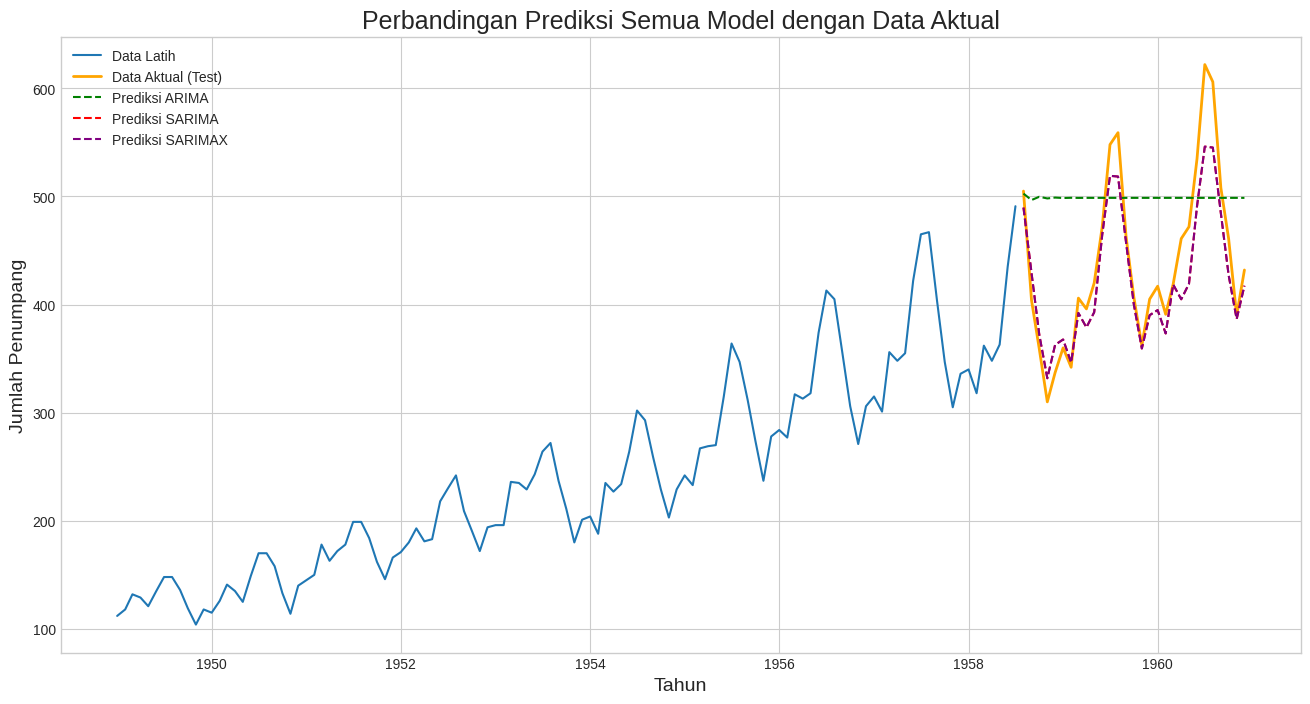

In [46]:
# Ringkasan Hasil Pengujian Model
print("\n--- Ringkasan Hasil Pengujian Model ---")
print(f"RMSE Model ARIMA: {rmse_arima:.2f}")
print(f"RMSE Model SARIMA: {rmse_sarima:.2f}")
print(f"RMSE Model SARIMAX: {rmse_sarimax:.2f}")

# Membandingkan RMSE untuk menentukan model terbaik
best_rmse = min(rmse_arima, rmse_sarima, rmse_sarimax)

if best_rmse == rmse_arima:
  print("\nModel terbaik adalah ARIMA berdasarkan RMSE.")
elif best_rmse == rmse_sarima:
  print("\nModel terbaik adalah SARIMA berdasarkan RMSE.")
else:
  print("\nModel terbaik adalah SARIMAX berdasarkan RMSE.")

# Visualisasi perbandingan semua model
plt.figure(figsize=(16, 8))
plt.plot(train_data.index, train_data, label='Data Latih')
plt.plot(test_data.index, test_data, label='Data Aktual (Test)', color='orange', linewidth=2)
plt.plot(predictions_arima.index, predictions_arima, label='Prediksi ARIMA', color='green', linestyle='--')
plt.plot(predictions_sarima.index, predictions_sarima, label='Prediksi SARIMA', color='red', linestyle='--')
plt.plot(predictions_sarimax.index, predictions_sarimax, label='Prediksi SARIMAX', color='purple', linestyle='--')
plt.title('Perbandingan Prediksi Semua Model dengan Data Aktual', fontsize=18)
plt.xlabel('Tahun', fontsize=14)
plt.ylabel('Jumlah Penumpang', fontsize=14)
plt.legend()
plt.show()

Dari proyek ini, dapat menarik beberapa kesimpulan:

1. ARIMA tidak cocok untuk data dengan musiman yang kuat. Model ini hanya menangkap tren umum dan menghasilkan error yang sangat tinggi.

2. SARIMA menunjukkan peningkatan performa yang dramatis. Dengan menambahkan komponen musiman, model ini mampu menangkap pola data yang kompleks (tren dan musiman) dengan sangat akurat, terbukti dari nilai RMSE yang jauh lebih rendah.

3. SARIMAX menawarkan fleksibilitas untuk menambahkan variabel eksternal. Meskipun dalam kasus kita dengan variabel tren buatan tidak memberikan banyak peningkatan, pada masalah dunia nyata di mana ada prediktor eksternal yang kuat, SARIMAX bisa menjadi model yang paling unggul.

Pemenangnya adalah SARIMA dan SARIMAX untuk dataset ini. Ini menyoroti pentingnya mengidentifikasi dan memodelkan musiman dengan benar dalam analisis deret waktu.

## Export Model

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import os

save_path = '/content/drive/MyDrive/PYTHON/Air-Passengers-Forcasting/model'

if not os.path.exists(save_path):
  os.makedirs(save_path)
  print(f"Direktori '{save_path}' berhasil dibuat.")

# ARIMA
arima_model_filename = os.path.join(save_path, 'arima_model.pkl')
fit_arima.save(arima_model_filename)
print(f"Model ARIMA berhasil disimpan di: {arima_model_filename}")

# SARIMA
sarima_model_filename = os.path.join(save_path, 'sarima_model.pkl')
fit_sarima.save(sarima_model_filename)
print(f"Model SARIMA berhasil disimpan di: {sarima_model_filename}")

# SARIMAX
sarimax_model_filename = os.path.join(save_path, 'sarimax_model.pkl')
fit_sarimax.save(sarimax_model_filename)
print(f"Model SARIMAX berhasil disimpan di: {sarimax_model_filename}")

Model ARIMA berhasil disimpan di: /content/drive/MyDrive/PYTHON/Air-Passengers-Forcasting/model/arima_model.pkl
Model SARIMA berhasil disimpan di: /content/drive/MyDrive/PYTHON/Air-Passengers-Forcasting/model/sarima_model.pkl
Model SARIMAX berhasil disimpan di: /content/drive/MyDrive/PYTHON/Air-Passengers-Forcasting/model/sarimax_model.pkl


In [49]:
!pipreqs "/content/drive/MyDrive/PYTHON/Air-Passengers-Forcasting/" --scan-notebooks --force

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/PYTHON/Air-Passengers-Forcasting/requirements.txt
